In [1]:
import numpy as np
import random
import json
import time
from kafka import KafkaProducer, KafkaConsumer
import matplotlib.pyplot as plt

## Variables de Ambiente

In [2]:
KAFKA_SERVER = 'lab9.alumchat.lol:9092'
TOPIC = '21438' 

## Simulación de Sensores

In [15]:
def get_temperature(mean_temp: int, std_dev: int):
    res = np.random.normal(mean_temp, std_dev, 1)
    res = np.clip(res, 0, 110)[0]
    return round(res, 2)

def get_humidity(mean_humidity: int, std_dev: int):
    humidity_sample = np.random.normal(mean_humidity, std_dev, 1)
    res = np.clip(humidity_sample, 0, 100)[0]
    return round(res, 2)

def get_wind_dir():
    directions = ["N", "NO", "O", "SO", "S", "SE", "E", "NE"]
    return random.choice(directions)

def to_dict(temp: int, humidity: int, wind_dir: str):
    dictionary = {
        "temperatura": temp,
        "humedad": humidity,
        "direccion_viento": wind_dir
    }

    return json.dumps(dictionary)

## Envío de Datos al Edge Server
Nota: El stream de datos debe detenerse manualmente, de forma que se levante un `KeyboardInterupt`.

In [13]:
def send_data(producer):
    while True:
        temperature = get_temperature(mean_temp=15, std_dev=5)
        humidity = get_humidity(mean_humidity=60, std_dev=15)    
        wind_dir = get_wind_dir()
        data = to_dict(temperature, humidity, wind_dir)

        # Genera y envía los datos        
        producer.send(TOPIC, data)
        print(f"Enviado: {data}")

        # Espera entre 15 y 30 segundos antes de enviar el siguiente dato
        time_to_sleep = random.randint(15, 30)
        time.sleep(time_to_sleep)

In [16]:
producer = KafkaProducer(
    bootstrap_servers=KAFKA_SERVER,
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

try:
    send_data(producer)
except KeyboardInterrupt:
    print("Process finished successfully")
finally:
    # Ensure all messages are sent
    producer.flush()
    producer.close()

Enviado: {"temperatura": 22.02, "humedad": 58.6, "direccion_viento": "NO"}
Process finished successfully


### Constancia
![images/producer.png](images/producer.png)

## Consumir y Desplegar Datos Meteorológicos

In [10]:
all_temp = []
all_hume = []
all_wind = []

def plot_all_data(temp_data, hume_data, wind_data):
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(temp_data, color='red', label='Temperatura')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(hume_data, color='blue', label='Humedad')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(wind_data, color='green', label='Dirección del viento')
    plt.legend()

    plt.tight_layout()
    plt.show()


def process_msg(mensaje):
    payload = json.loads(mensaje.value)
    payload = json.loads(payload)
    return {
        'temperatura': payload.get('temperatura'),
        'humedad': payload.get('humedad'),
        'direccion_viento': payload.get('direccion_viento')
    }

def consume_events(consumer):
    # Consume mensajes y procesa los datos
    for msg in consumer:
        print(msg)
        payload = process_msg(msg)
        
        # Agrega los datos a las listas
        all_temp.append(payload['temperatura'])
        all_hume.append(payload['humedad'])
        all_wind.append(payload['direccion_viento'])


ConsumerRecord(topic='21438', partition=0, offset=59, timestamp=1730685480536, timestamp_type=0, key=None, value='"{\\"temperatura\\": 19.83, \\"humedad\\": 52.77, \\"direccion_viento\\": \\"O\\"}"', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=75, serialized_header_size=-1)
ConsumerRecord(topic='21438', partition=0, offset=60, timestamp=1730685507541, timestamp_type=0, key=None, value='"{\\"temperatura\\": 13.68, \\"humedad\\": 69.75, \\"direccion_viento\\": \\"SE\\"}"', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=76, serialized_header_size=-1)
ConsumerRecord(topic='21438', partition=0, offset=61, timestamp=1730685528546, timestamp_type=0, key=None, value='"{\\"temperatura\\": 14.74, \\"humedad\\": 83.4, \\"direccion_viento\\": \\"N\\"}"', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=74, serialized_header_size=-1)
ConsumerRecord(topic='21438', partition=0, offset=62, timestamp=1730685557551, timestamp

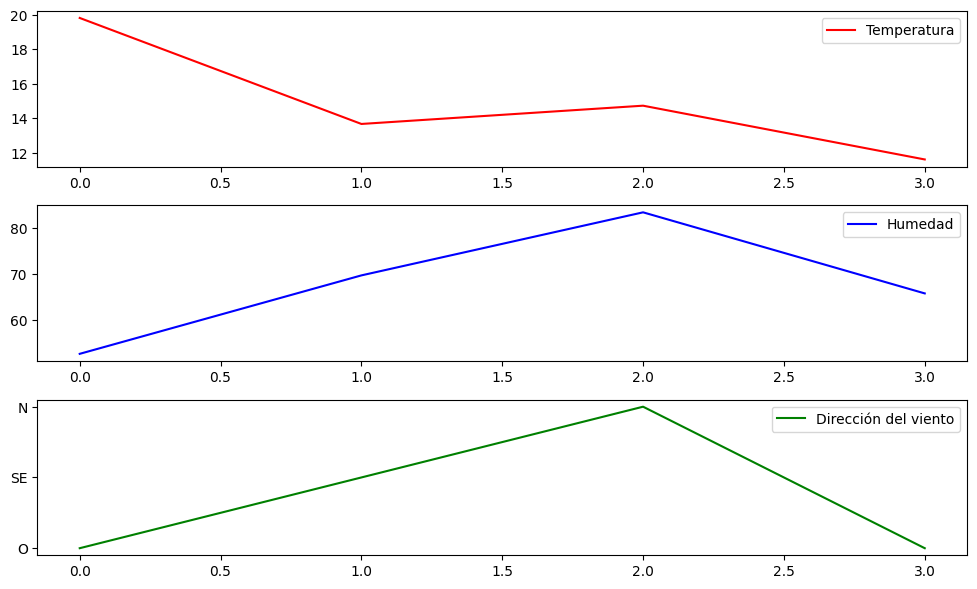

In [11]:
consumer = KafkaConsumer(
    TOPIC,    
    bootstrap_servers=KAFKA_SERVER,  
    value_deserializer=lambda x: x.decode('utf-8')
)

try:
    consume_events(consumer)
except KeyboardInterrupt:
    print("Process finished successfully")
finally:     
    consumer.close()
    # Realiza un análisis o graficación de los datos
    plot_all_data(all_temp, all_hume, all_wind)

## IoT en Entornos con Restricciones